In [6]:
import glob
import os
import sys
import time
from pathlib import Path
from pydoc import locate
from typing import List, Tuple

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import (average_precision_score, precision_recall_curve,
                             roc_auc_score, roc_curve, recall_score, precision_score)

from matplotlib import pyplot as plt

from termcolor import colored
from torch.autograd import Variable

sys.path.insert(0, str(Path.cwd() / 'preparation/'))
sys.path.insert(0, str(Path.cwd() / 'training/'))

import data_loader

In [7]:
map = 'inferno'

#Results to analyze
result_location_first_part = f"test_results/big_data_8_all_player"

print(result_location_first_part)

test_results/big_data_8_all_player


In [8]:
PATH_TO_MATCHES = Path('../../csgo_dataset/processed_files/')
PATH_TO_DEATHS = Path('../../csgo_dataset/parsed_files_test/')
chosen_match = 'astralis-vs-cloud9-inferno.feather' #INSERT MATCH HERE
chosen_match_deaths = 'astralis-vs-cloud9-inferno_deaths.csv'

chosen_match_path = PATH_TO_MATCHES / chosen_match
chosen_match_deaths_path = PATH_TO_DEATHS / chosen_match_deaths

all_test_matches_path = Path('../../csgo_dataset/test_data/')
#Load matches with matching map
all_test_matches = data_loader.get_files_in_directory(all_test_matches_path, f'{map}.feather')

print(len(all_test_matches), ' test matches')
print(Path(chosen_match_deaths_path))

20  test matches
../../csgo_dataset/parsed_files_test/astralis-vs-cloud9-inferno_deaths.csv


In [27]:
#Load precitions and ground truth values for all tested matches and their match indecies (ticks)
pred_and_lab = np.load(f'{result_location_first_part}_predictions_and_labels.npy', allow_pickle=True)

labels = pred_and_lab[1]
pred = pred_and_lab[0]
match_indecies = np.load(f'{result_location_first_part}_match_indecies.npy', allow_pickle=True)

In [10]:
fracs = []
for i in range(10):
    for l in labels:
        fracs.append(len(l[l[:,i] > 0])/len(l))

print(str(np.array(fracs).mean()) + " is the percentage of positive labels (death) in the test dataset for each player")




0.03770695358707235 is the percentage of positive labels (death) in the test dataset for each player


In [12]:
print(len(match_indecies),'Amount matches in test set')

20 Amount matches in test set


In [15]:
all_avg_score = []

for l,p in zip(labels, pred):
    all_avg_score.append(average_precision_score(l.reshape(-1), p.reshape(-1)))

print(np.array(all_avg_score).mean(), 'Average Precision score mean over all test matches')

0.2059828106012167 Average Precision score mean over all test matches


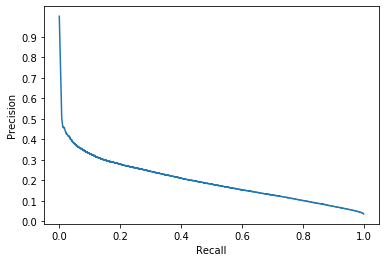

In [28]:
#CREATE PRECISION RECALL CURVES USING PREDICTIONS AND LABELS FOR ALL MATCHES
all_lab = []
all_pred = []

for l,p in zip(labels, pred):
    all_lab.extend(l.reshape(-1).tolist())
    all_pred.extend(p.reshape(-1).tolist())

#precision, recall, thresholds = precision_recall_curve(labels[13].reshape(-1),pred[13].reshape(-1))
precision, recall, thresholds = precision_recall_curve(all_lab,all_pred)
#r = precision_score(all_lab,all_pred)

plt.plot(recall, precision)
plt.yticks(np.arange(0, 1, 0.1))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.savefig(f'{result_location_first_part}/PR_curve.png', dpi=400,bbox_inches='tight')

Text(0.5, 0, 'Thresholds')

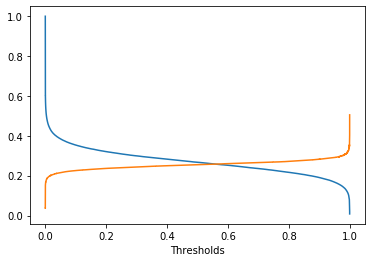

In [29]:
#PRECISION AND RECALL RELATIVE TO THRESHOLDS

plt.plot(thresholds,recall[:-1])
plt.plot(thresholds, precision[:-1])
plt.xlabel('Thresholds')


In [44]:
#Generate graphic of one match in test set

match_id = 13

heroStuff1 =  pred[match_id]    # np.load('hero.npy')
labelStuff1 = labels[match_id]

print(len(labels[match_id]))
print(len(pred[match_id]))
print(len(match_indecies[match_id]))

death_times = pd.read_csv(chosen_match_deaths_path)[['Tick','VictimIndex','AttackerIndex']].astype(int)
death_times_with_names = pd.read_csv(chosen_match_deaths_path)
xLims = np.linspace(match_indecies[match_id].min(),match_indecies[match_id].max(), num=pred[match_id].shape[0]) 
xLabels = np.linspace(match_indecies[match_id].min(),match_indecies[match_id].max(), num=20) 
#np.repeat(np.linspace(0,1,all_pred[3][0].shape[0]).reshape(-1,1),10,axis=1)     # np.load('xLims.npy')

print(death_times_with_names.columns)

#healthes = np.load('health.npy')
clip = 0.5

heroStuff1 = np.clip(heroStuff1,clip,1)
heroStuff1 = np.interp(heroStuff1, (heroStuff1.min(), heroStuff1.max()), (0, +1))
heroStuff1 = (heroStuff1 -1)
    
players = [0,1,2,3,4,5,6,7,8,9]
graphIndex =0
f, axarr = plt.subplots(len(players), sharex=True, sharey=True)
for i in players:
    ticks = ['no kill','kill']
    result = death_times[death_times['VictimIndex'] == i]['Tick'].to_numpy()
    result_kills = death_times[death_times['AttackerIndex'] == i]['Tick'].to_numpy()

    yLims = np.full(result.size, 0.9)
    yLims_kills = np.full(result_kills.size, 0)
    
    victimName = death_times_with_names[death_times_with_names['VictimIndex'] == i].iloc[0]['VictimName']

    player_preds = pred[match_id][:,i]
    
    axarr[i].plot(xLims, player_preds ,color='red',linewidth=0.5)
    axarr[i].scatter(result,yLims,s=50 , marker ="|",color='black')
    axarr[i].scatter(result_kills,yLims_kills, marker ="|" ,color='green')
    #ticks = ['no kill','NK','K']
    #axarr[i].set_yticklabels(ticks)
    axarr[i].yaxis.set_label_coords(-0.045,0.5)
    if graphIndex < 5:
        axarr[i].set_ylabel(victimName,color = 'red', rotation=0)
    else:
        axarr[i].set_ylabel(victimName,color = 'blue', rotation=0)
    graphIndex +=1
    

f.subplots_adjust(hspace=0.5)
f.set_figwidth(15)

plt.xlabel('time measures in game ticks')
plt.figtext(0.05, 0.2, "Death Prediction for Players\nGreen lines: Kill, Black lines:Death",rotation = 90)
plt.gcf().autofmt_xdate()
graphIndex =0
plt.savefig(f'{result_location_first_part}/gamePrediction.png', dpi=400,bbox_inches='tight')
plt.show()



25114
25114
25114
Index(['Round', 'Tick', 'Time', 'AttackerIndex', 'AttackerName', 'VictimIndex',
       'VictimName'],
      dtype='object')


ValueError: x and y must have same first dimension, but have shapes (11,) and (25114,)

In [40]:
r_pred = np.random.rand(pred[0].shape[0] * 10)

average_precision_score(labels[0].reshape(-1), r_pred)


0.038859709998351706

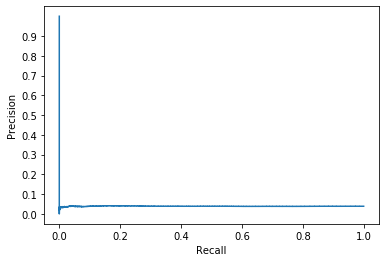

In [43]:
precision, recall, thresholds = precision_recall_curve(labels[0].reshape(-1), r_pred.reshape(-1)) 
#pr = precision_score(labels.reshape(-1).astype(np.float32), pred.reshape(-1).astype(np.float32))

plt.plot(recall, precision)
plt.yticks(np.arange(0, 1, 0.1))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.savefig('PR_curve_random.png', dpi=400,bbox_inches='tight')